# AIPI 590 - XAI | Assignment #05
### GradCAM & Computer Vision
### Peter Banyas

#### Include the button below. Change the link to the location in your github repository:
#### Example: https://colab.research.google.com/github/banyasp/aipi590_hw5_gradCAM/blob/main/report.ipynb


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/banyasp/aipi590_hw5_gradCAM/blob/main/report.ipynb)

## Setup and Installation

This notebook demonstrates various Class Activation Mapping (CAM) techniques on facial emotion images using a pretrained ResNet50 model.


In [5]:
# Install required packages
%pip install grad-cam pillow torch torchvision


In [6]:
# Clone the repository to get the data folder
import os
if not os.path.exists('aipi590_hw5_gradCAM'):
    os.system('git clone https://github.com/banyasp/aipi590_hw5_gradCAM.git')
    print("Repository cloned successfully!")
else:
    print("Repository already exists!")


Repository already exists!


In [7]:
# built with cursor oct 6; see ./cursor_logs
# Import required libraries
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, ScoreCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image
import torch
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
import ssl
import time

# Fix SSL certificate verification issue
ssl._create_default_https_context = ssl._create_unverified_context

# Create output directory if it doesn't exist
os.makedirs('output', exist_ok=True)

print("✓ All libraries imported successfully!")
print(f"✓ Using device: {'GPU' if torch.cuda.is_available() else 'CPU'}")


✓ All libraries imported successfully!
✓ Using device: GPU


## Load Model and Define CAM Processing Function


In [8]:
# built with cursor oct 6; see ./cursor_logs

# Load pretrained ResNet50 model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model = model.to(device)
model.eval()

# Target layer (last convolutional layer in ResNet50)
target_layers = [model.layer4[-1]]

# Initialize CAM methods
cam_algorithms = {
    'GradCAM': GradCAM(model=model, target_layers=target_layers),
    'GradCAM++': GradCAMPlusPlus(model=model, target_layers=target_layers),
    'EigenCAM': EigenCAM(model=model, target_layers=target_layers),
    'Score-CAM': ScoreCAM(model=model, target_layers=target_layers)
}

print("✓ Model loaded successfully!")
print(f"✓ Initialized {len(cam_algorithms)} CAM algorithms")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 159MB/s]


✓ Model loaded successfully!
✓ Initialized 4 CAM algorithms


In [9]:
def process_single_image(img_name, display=True):
    """
    Process a single image with all CAM methods and optionally display results.

    Parameters:
    -----------
    img_name : str
        Name of the image file (without .jpg extension)
    display : bool
        Whether to display the results inline (default: True)

    Returns:
    --------
    dict : Contains processing information and results
    """
    print(f"\n{'='*60}")
    print(f"Processing image: {img_name}")
    print(f"{'='*60}")

    # Load and preprocess image from the data folder
    img_path = f'aipi590_hw5_gradCAM/data/{img_name}.jpg'
    img = Image.open(img_path).convert('RGB')
    img_resized = img.resize((224, 224))
    img_array = np.array(img_resized) / 255.0
    img_tensor = transforms.ToTensor()(img_resized).unsqueeze(0).to(device)

    # Generate visualizations for all methods
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))

    # Original image
    axes[0].imshow(img_resized)
    axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # Generate CAM for each method
    for idx, (name, cam) in enumerate(cam_algorithms.items(), 1):
        print(f"  Generating {name}...")
        grayscale_cam = cam(input_tensor=img_tensor, targets=None)
        visualization = show_cam_on_image(img_array, grayscale_cam[0], use_rgb=True)

        axes[idx].imshow(visualization)
        axes[idx].set_title(name, fontsize=14, fontweight='bold')
        axes[idx].axis('off')

        # Save individual visualizations
        output_img = Image.fromarray(visualization)
        output_path = f'output/{name.lower().replace("-", "")}_output_{img_name}.jpg'
        output_img.save(output_path)
        print(f"    Saved {output_path}")

    # Save comparison
    plt.tight_layout()
    comparison_path = f'output/cam_comparison_{img_name}.png'
    plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
    print(f"  Comparison saved as '{comparison_path}'")

    if display:
        plt.show()
    else:
        plt.close()

    # Get model prediction
    with torch.no_grad():
        output = model(img_tensor)
        pred_class = output.argmax(dim=1).item()
        confidence = torch.softmax(output, dim=1)[0][pred_class].item()
        print(f"  Predicted class index: {pred_class}")
        print(f"  Confidence: {confidence:.2%}")

    return {
        'image_name': img_name,
        'predicted_class': pred_class,
        'confidence': confidence
    }

print("✓ Processing function defined!")


✓ Processing function defined!


## Process All Images

Now we'll process all 12 images from the dataset using all four CAM methods.



Starting CAM processing
Total images to process: 12


Processing image: happy_01932
  Generating GradCAM...
    Saved output/gradcam_output_happy_01932.jpg
  Generating GradCAM++...
    Saved output/gradcam++_output_happy_01932.jpg
  Generating EigenCAM...
    Saved output/eigencam_output_happy_01932.jpg
  Generating Score-CAM...


100%|██████████| 128/128 [00:07<00:00, 16.73it/s]


    Saved output/scorecam_output_happy_01932.jpg
  Comparison saved as 'output/cam_comparison_happy_01932.png'


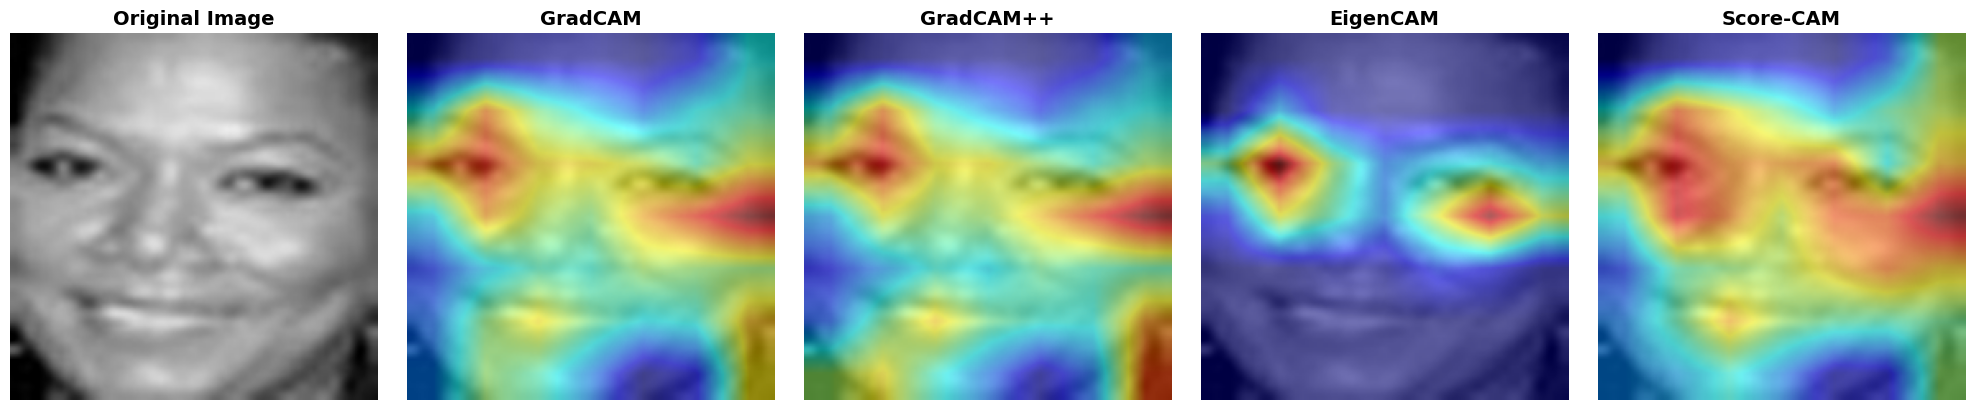

  Predicted class index: 906
  Confidence: 18.15%

Processing image: happy_01419
  Generating GradCAM...
    Saved output/gradcam_output_happy_01419.jpg
  Generating GradCAM++...
    Saved output/gradcam++_output_happy_01419.jpg
  Generating EigenCAM...
    Saved output/eigencam_output_happy_01419.jpg
  Generating Score-CAM...


100%|██████████| 128/128 [00:07<00:00, 17.62it/s]


    Saved output/scorecam_output_happy_01419.jpg
  Comparison saved as 'output/cam_comparison_happy_01419.png'


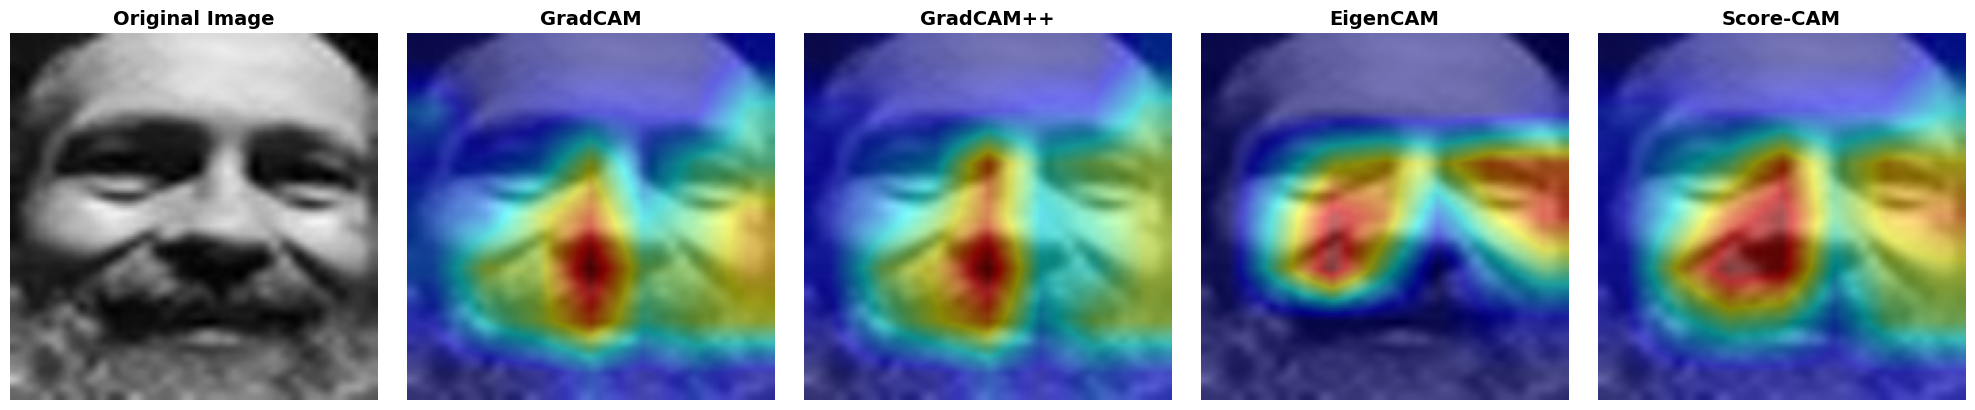

  Predicted class index: 715
  Confidence: 12.67%

Processing image: disgust_00024
  Generating GradCAM...
    Saved output/gradcam_output_disgust_00024.jpg
  Generating GradCAM++...
    Saved output/gradcam++_output_disgust_00024.jpg
  Generating EigenCAM...
    Saved output/eigencam_output_disgust_00024.jpg
  Generating Score-CAM...


100%|██████████| 128/128 [00:07<00:00, 16.73it/s]


    Saved output/scorecam_output_disgust_00024.jpg
  Comparison saved as 'output/cam_comparison_disgust_00024.png'


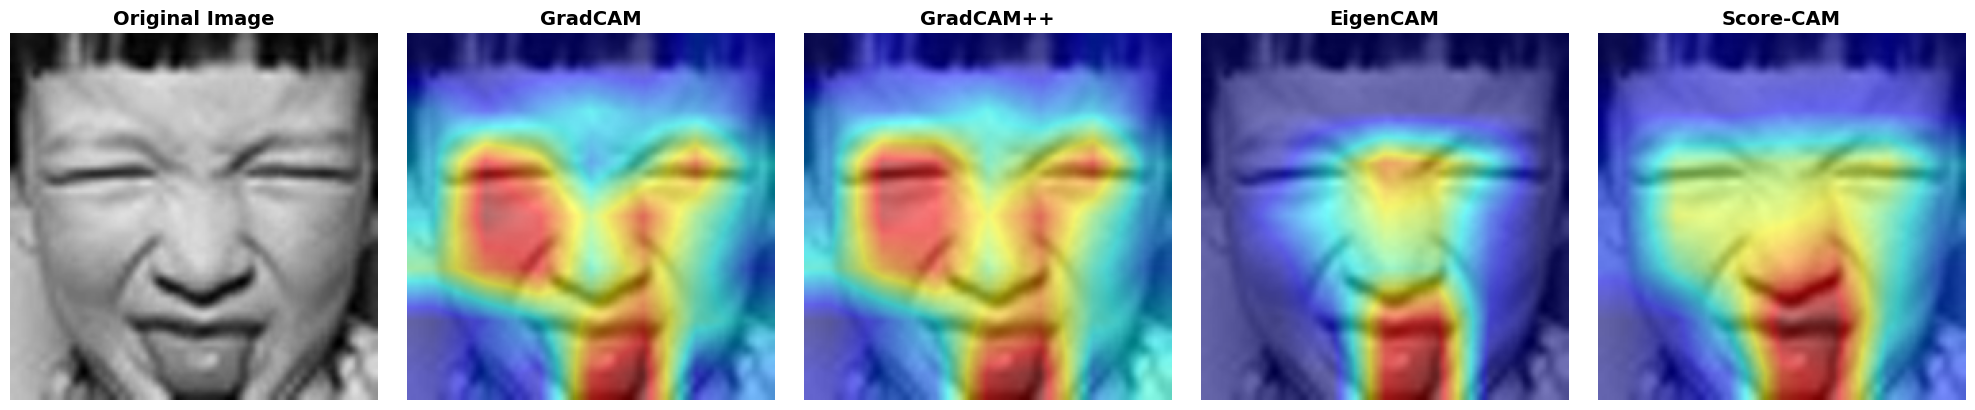

  Predicted class index: 715
  Confidence: 28.41%

Processing image: disgust_00045
  Generating GradCAM...
    Saved output/gradcam_output_disgust_00045.jpg
  Generating GradCAM++...
    Saved output/gradcam++_output_disgust_00045.jpg
  Generating EigenCAM...
    Saved output/eigencam_output_disgust_00045.jpg
  Generating Score-CAM...


100%|██████████| 128/128 [00:07<00:00, 16.32it/s]


    Saved output/scorecam_output_disgust_00045.jpg
  Comparison saved as 'output/cam_comparison_disgust_00045.png'


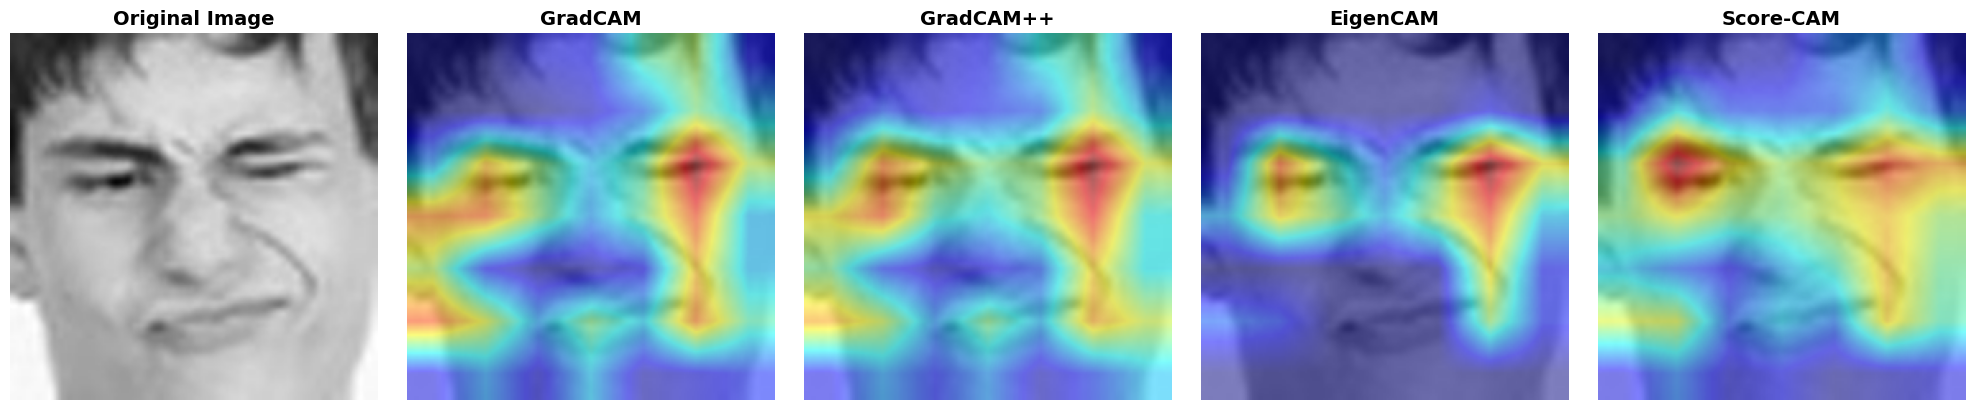

  Predicted class index: 715
  Confidence: 23.08%

Processing image: angry_00009
  Generating GradCAM...
    Saved output/gradcam_output_angry_00009.jpg
  Generating GradCAM++...
    Saved output/gradcam++_output_angry_00009.jpg
  Generating EigenCAM...
    Saved output/eigencam_output_angry_00009.jpg
  Generating Score-CAM...


100%|██████████| 128/128 [00:06<00:00, 19.74it/s]


    Saved output/scorecam_output_angry_00009.jpg
  Comparison saved as 'output/cam_comparison_angry_00009.png'


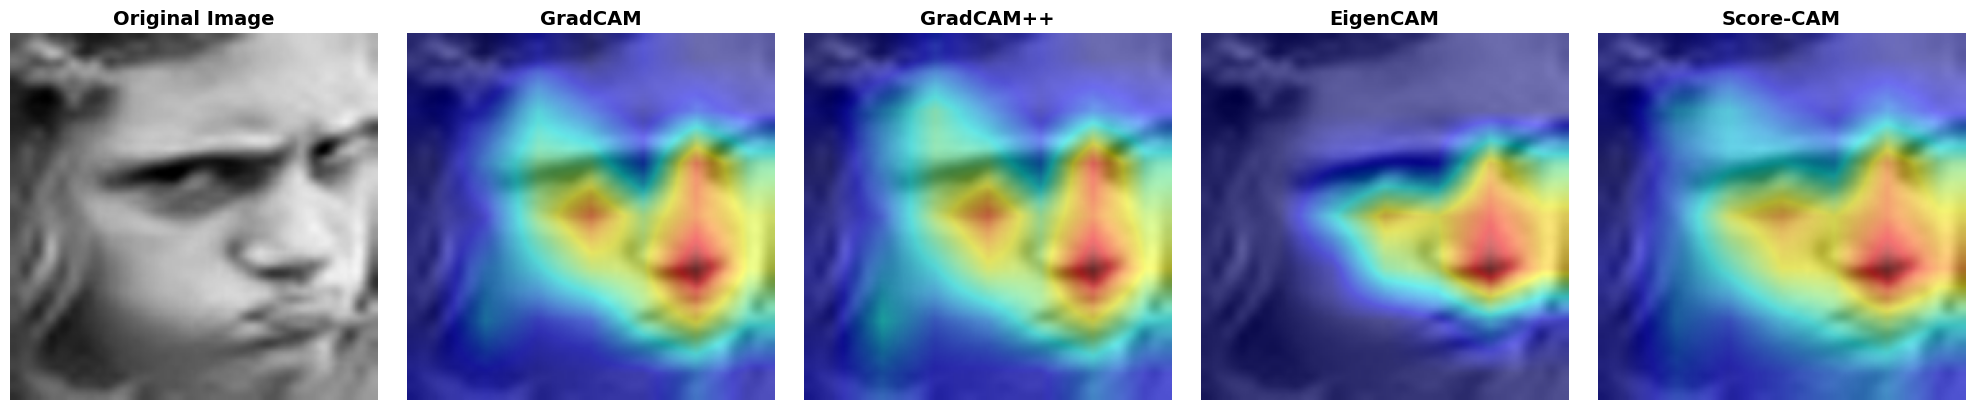

  Predicted class index: 715
  Confidence: 30.40%

Processing image: angry_00021
  Generating GradCAM...
    Saved output/gradcam_output_angry_00021.jpg
  Generating GradCAM++...
    Saved output/gradcam++_output_angry_00021.jpg
  Generating EigenCAM...
    Saved output/eigencam_output_angry_00021.jpg
  Generating Score-CAM...


100%|██████████| 128/128 [00:06<00:00, 19.07it/s]


    Saved output/scorecam_output_angry_00021.jpg
  Comparison saved as 'output/cam_comparison_angry_00021.png'


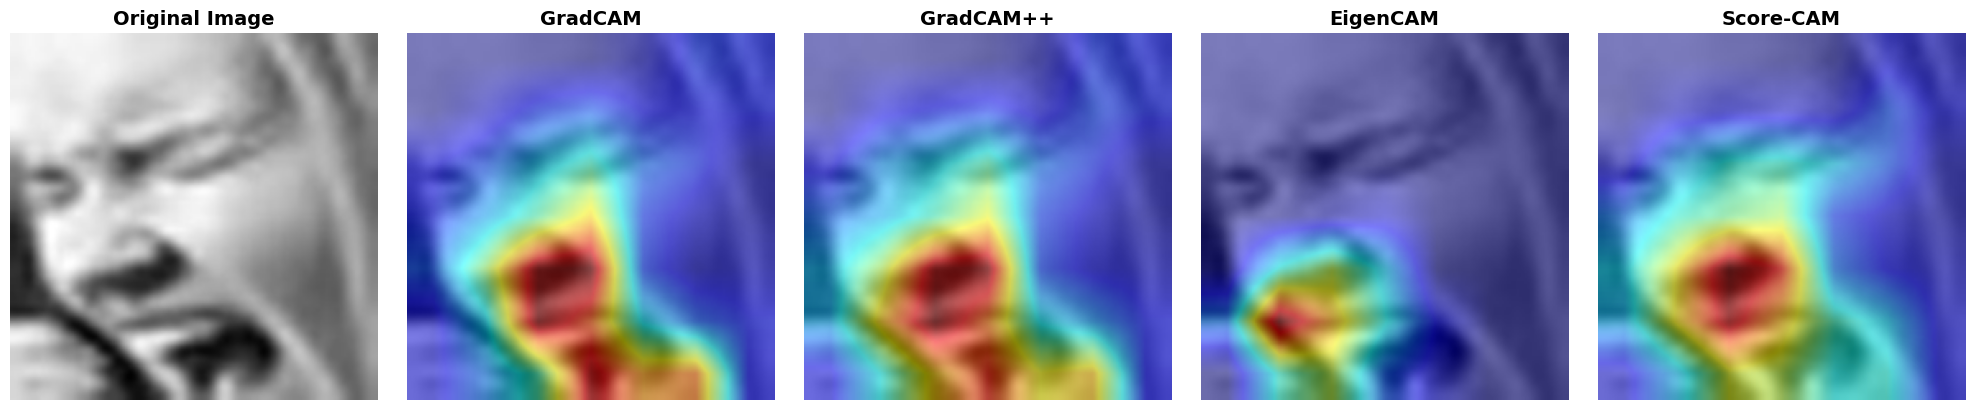

  Predicted class index: 714
  Confidence: 5.59%

Processing image: surprise_00007
  Generating GradCAM...
    Saved output/gradcam_output_surprise_00007.jpg
  Generating GradCAM++...
    Saved output/gradcam++_output_surprise_00007.jpg
  Generating EigenCAM...
    Saved output/eigencam_output_surprise_00007.jpg
  Generating Score-CAM...


100%|██████████| 128/128 [00:08<00:00, 15.83it/s]


    Saved output/scorecam_output_surprise_00007.jpg
  Comparison saved as 'output/cam_comparison_surprise_00007.png'


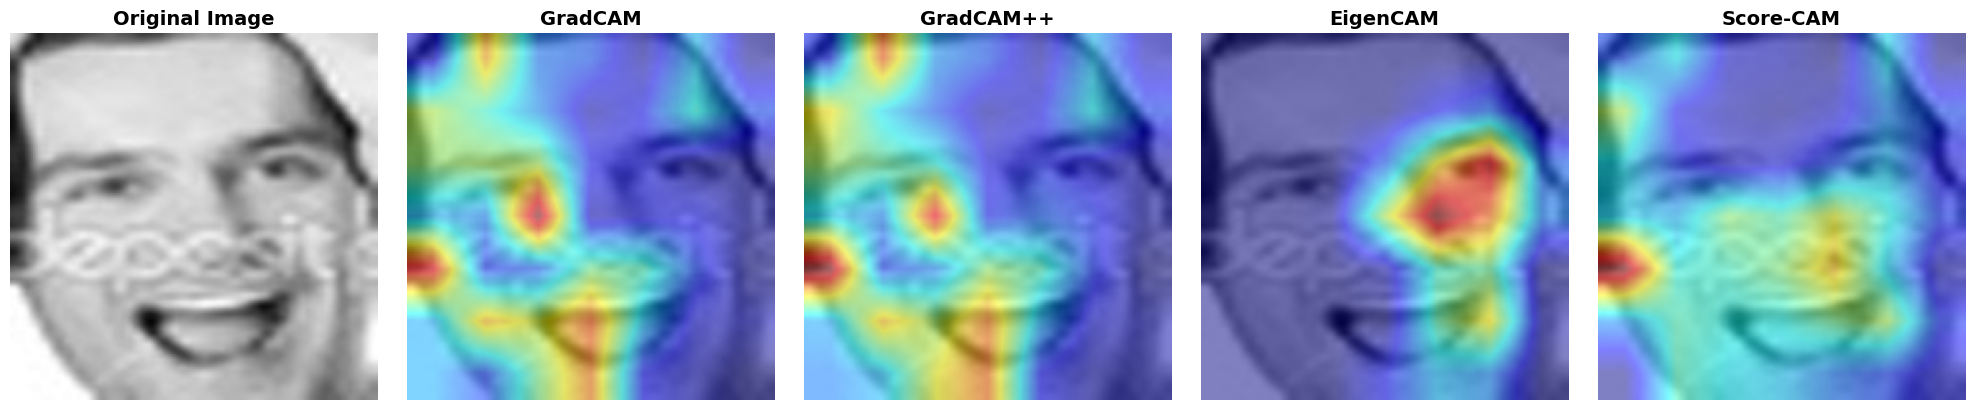

  Predicted class index: 111
  Confidence: 14.69%

Processing image: surprise_00019
  Generating GradCAM...
    Saved output/gradcam_output_surprise_00019.jpg
  Generating GradCAM++...
    Saved output/gradcam++_output_surprise_00019.jpg
  Generating EigenCAM...
    Saved output/eigencam_output_surprise_00019.jpg
  Generating Score-CAM...


100%|██████████| 128/128 [00:07<00:00, 17.00it/s]


    Saved output/scorecam_output_surprise_00019.jpg
  Comparison saved as 'output/cam_comparison_surprise_00019.png'


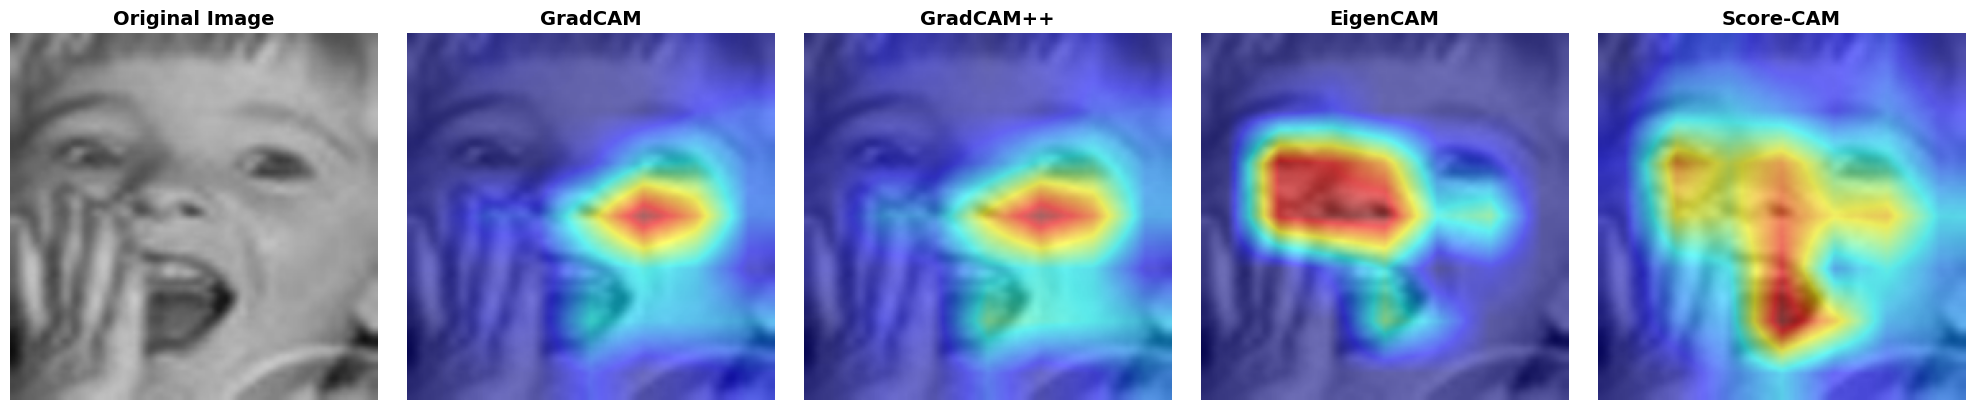

  Predicted class index: 680
  Confidence: 10.59%

Processing image: sad_00007
  Generating GradCAM...
    Saved output/gradcam_output_sad_00007.jpg
  Generating GradCAM++...
    Saved output/gradcam++_output_sad_00007.jpg
  Generating EigenCAM...
    Saved output/eigencam_output_sad_00007.jpg
  Generating Score-CAM...


100%|██████████| 128/128 [00:06<00:00, 19.52it/s]


    Saved output/scorecam_output_sad_00007.jpg
  Comparison saved as 'output/cam_comparison_sad_00007.png'


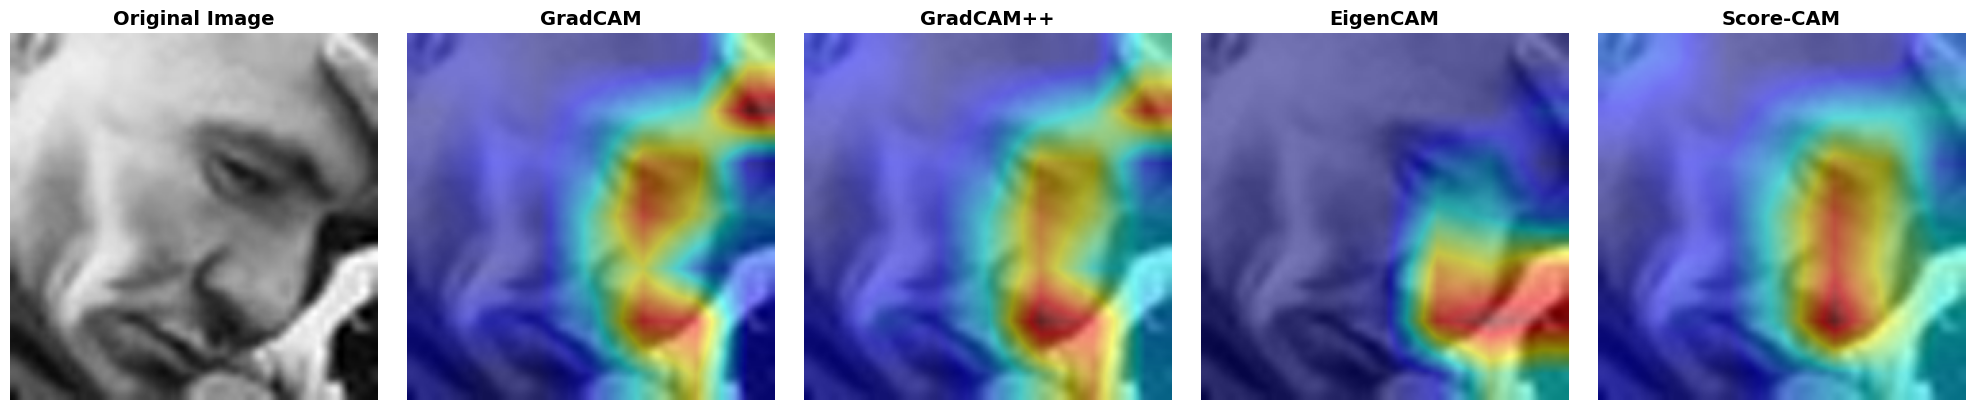

  Predicted class index: 678
  Confidence: 3.40%

Processing image: sad_00018
  Generating GradCAM...
    Saved output/gradcam_output_sad_00018.jpg
  Generating GradCAM++...
    Saved output/gradcam++_output_sad_00018.jpg
  Generating EigenCAM...
    Saved output/eigencam_output_sad_00018.jpg
  Generating Score-CAM...


100%|██████████| 128/128 [00:06<00:00, 19.26it/s]


    Saved output/scorecam_output_sad_00018.jpg
  Comparison saved as 'output/cam_comparison_sad_00018.png'


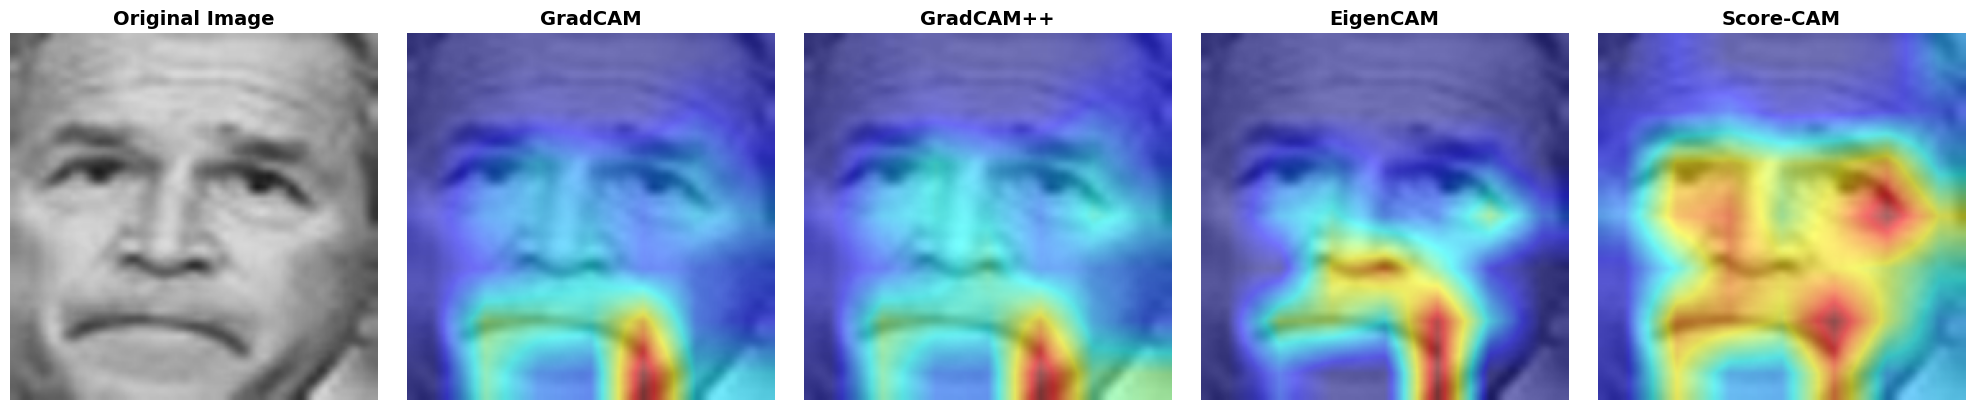

  Predicted class index: 678
  Confidence: 23.74%

Processing image: neutral_00017
  Generating GradCAM...
    Saved output/gradcam_output_neutral_00017.jpg
  Generating GradCAM++...
    Saved output/gradcam++_output_neutral_00017.jpg
  Generating EigenCAM...
    Saved output/eigencam_output_neutral_00017.jpg
  Generating Score-CAM...


100%|██████████| 128/128 [00:06<00:00, 19.24it/s]


    Saved output/scorecam_output_neutral_00017.jpg
  Comparison saved as 'output/cam_comparison_neutral_00017.png'


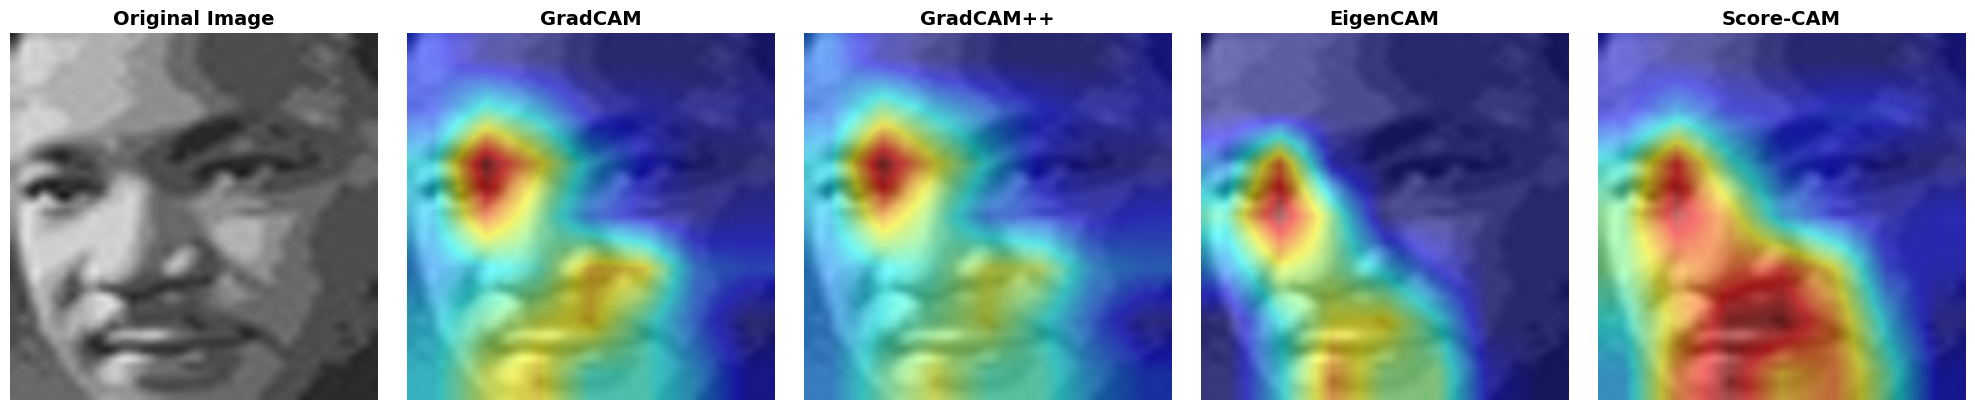

  Predicted class index: 715
  Confidence: 60.56%

Processing image: neutral_00025
  Generating GradCAM...
    Saved output/gradcam_output_neutral_00025.jpg
  Generating GradCAM++...
    Saved output/gradcam++_output_neutral_00025.jpg
  Generating EigenCAM...
    Saved output/eigencam_output_neutral_00025.jpg
  Generating Score-CAM...


100%|██████████| 128/128 [00:06<00:00, 19.05it/s]


    Saved output/scorecam_output_neutral_00025.jpg
  Comparison saved as 'output/cam_comparison_neutral_00025.png'


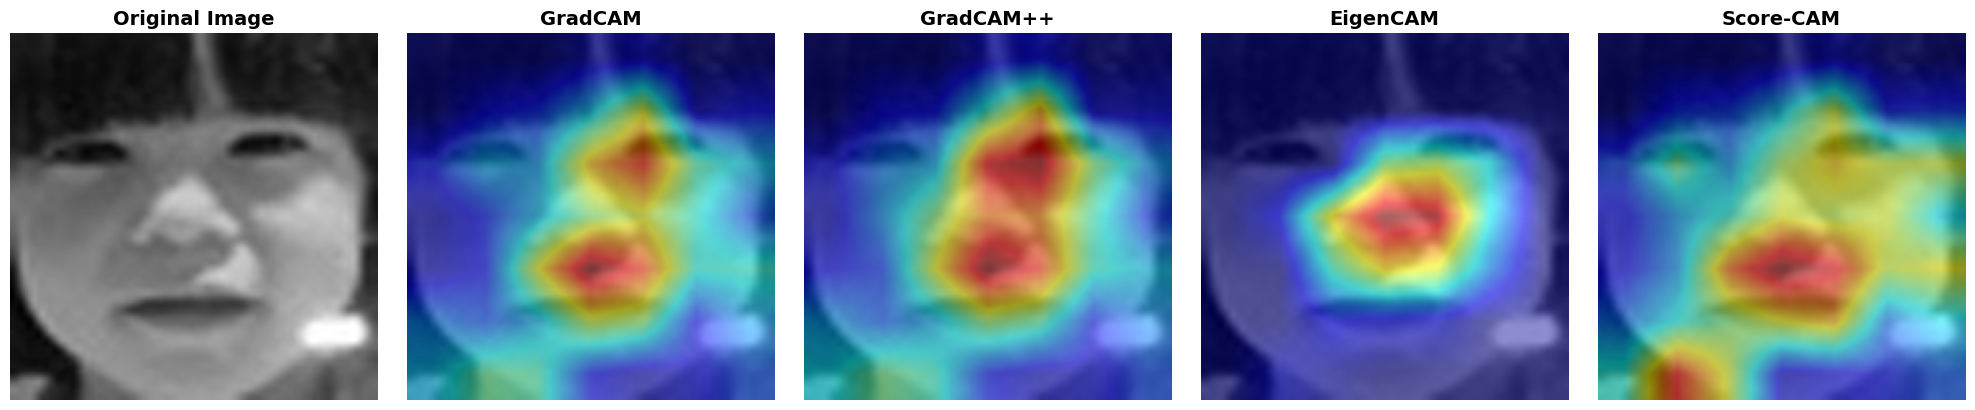

  Predicted class index: 715
  Confidence: 69.04%

✓ All 12 images processed successfully!
Total time: 117.19 seconds
Average time per image: 9.77 seconds


In [10]:
# List of images to process
img_list = [
    'happy_01932',
    'happy_01419',
    'disgust_00024',
    'disgust_00045',
    'angry_00009',
    'angry_00021',
    'surprise_00007',
    'surprise_00019',
    'sad_00007',
    'sad_00018',
    'neutral_00017',
    'neutral_00025'
]

# Process all images
print(f"\n{'='*60}")
print(f"Starting CAM processing")
print(f"Total images to process: {len(img_list)}")
print(f"{'='*60}\n")

start_time = time.time()
results = []

for img_name in img_list:
    result = process_single_image(img_name, display=True)
    results.append(result)

elapsed_time = time.time() - start_time

print(f"\n{'='*60}")
print(f"✓ All {len(img_list)} images processed successfully!")
print(f"Total time: {elapsed_time:.2f} seconds")
print(f"Average time per image: {elapsed_time/len(img_list):.2f} seconds")
print(f"{'='*60}")


## Results Summary

Let's view a summary of all processed images and their predictions.


In [11]:
# Display results summary
import pandas as pd

df = pd.DataFrame(results)
df.index = df.index + 1
df.columns = ['Image Name', 'Predicted Class', 'Confidence']
df['Confidence'] = df['Confidence'].apply(lambda x: f"{x:.2%}")

print("\nSummary of All Predictions:")
print("="*60)
print(df.to_string())
print("="*60)



Summary of All Predictions:
        Image Name  Predicted Class Confidence
1      happy_01932              906     18.15%
2      happy_01419              715     12.67%
3    disgust_00024              715     28.41%
4    disgust_00045              715     23.08%
5      angry_00009              715     30.40%
6      angry_00021              714      5.59%
7   surprise_00007              111     14.69%
8   surprise_00019              680     10.59%
9        sad_00007              678      3.40%
10       sad_00018              678     23.74%
11   neutral_00017              715     60.56%
12   neutral_00025              715     69.04%


**Dataset & Motivation**
I chose to use the ResNet-50 as well as the Facial Emotion Image Dataset that I found on Kaggle [https://www.kaggle.com/datasets/fahadullaha/facial-emotion-recognition-dataset/data].

This is an important domain because Duke keeps installing more surveillance cameras around campus. Now I need to know how I need to comport my face so that the Duke AI overlord thinks that I am happy or neutral and definitely not disgusted, angry, surprised, or sad.  Using GradCAM will help with explainability so that we can understand what features on the face it's looking at to make those decisions.

I chose to use two images of each class to run this test on. That meant two of each of the happy, disgusted, angry, surprised, sad, neutral faces.

**GradCAM variants**
I used four different types of GradCam so that I could really see the breadth of how different implementations of these explainability techniques can lead to different results.

1. **GradCAM**: Standard process. This computes the gradient of the target class score with respect to the feature maps in the convolutional layer. It then takes the global average of those gradients to get importance weights for each feature map.  Those weights are then used to do a weighted sum of the feature maps. Lastly, ReLU is used to focus on positive influences.

2. **GradCAM++**: This is a little different than regular GradCAM in that it uses a weighted average of gradients rather than simple averaging. It also involves second and third-order derivatives to compute pixel-wise weights.

3. **EigenCAM**: This method uses principal component analysis in the activation maps so that we can find the most dominant spatial pattern that the model is using. It's basically a focusing tool.

4. **Score-CAM**: This one is a big twist because it actually doesn't use backpropagation and gradients at all. Instead, for each activation map, it creates a mask and runs a forward pass. Then it scores each activation map based on how much it increases target class probability, and finally it weighs the activation maps by those scores.

# **Analysis**
**Happy**
Looking at the first happy image, we can see that GradCAM and GradCAM++ look fairly similar, with attention being shown to:
- The left eye
- The wrinkles under the right eye
- A little bit of the mouth and chin
This feels intuitive because people smile with their eyes and with their lips.

EigenCAM, on the other hand, doesn't include any emphasis on the lips and instead just focuses on the left eye and right eye wrinkles. This is focusing because it basically drops out the less influential parts of GradCAM.

Lastly, ScoreCAM is really all over the place, including:
- a broader range of the left eye, including underneath it and how it connects to the nose
- a lot more of the right cheek and the right eye wrinkles
- the smile again

For the second happy image, we see some really confusing results. We see that it is focused on the left nostril for GradCAM and GradCAM++, which feels very unintuitive. EigenCAM and ScoreCAM focus on the left of the nose as well, but also blur into the eye wrinkles. This feels slightly more intuitive because this man smiles with his cheeks. It's worth noting that since this face doesn't really have much of a mouth, it doesn't focus on the lips pretty much at all.


**Disgust**
In the first image, across all four CAM models, we see it focusing on the tongue as the most important factor, which makes a lot of sense because sticking out someone's tongue is a very clear indicator of disgust. However, the different CAM models vary in the degree to which they focus on the eyes.

For the second image, we see really discordant mappings for GradCAM and GradCAM++ but this could be explained by the odd contortion of the face. We see the map mainly focused on the right eye which feels intuitive but it also includes the left cheekbone in the outside of the face. Perhaps it's noticing that there's an odd shape that implies that there is contortion in the face and therefore that is indicative of disgust which makes sense. For EigenCAM, we see that it is primarily focused on the right eye and the cheek contortion, while ScoreCAM has a blend.

**Anger**
In the Angry images, we see a lot of focus on the nose. Across all different CAM models, the bottom of the nose is very indicative, including across both images. Involvement from the eyes. So those play a role. Whereas the second image has this open screaming mouth which is also indicative of the anger. This makes sense because it shows that the CAM models are attending to the relevant features that show up in an image and there may be multiple different features that don't always happen together. Each of which contributes to the overall classification.

**Surprise**
The first surprise image I intentionally chose because it has a watermark on it, and I wanted to see how that would affect how the GradCam models work. We see that there is a lot of confusion going on, as I suspected. The GradCAM, GradCAM++, & ScoreCAM models focus on the letter D as the primary indicator of the features, which just doesn't feel right. It also includes a broad scattering of areas throughout the image. On the other hand, eigenCAM focuses on the right eye and right side of the nose, which offers some intuitive explanations. It's worth noting that the confidence score on this image is 14%, which is extremely low.

For the second surprise image, we see very different attention maps for the different CAM models. GradCAM and GradCAM++ are focused on the cheek section right below the right eye, which makes sense because the child is raising his face with excitement. But on the other hand, iCAM and ScoreCAM are focused on different features, including the nose and the open mouth, respectively. The math feels intuitive, but I don't really understand the relevance of the nose.

**Sad**
For the first sad image, it focuses only on the side of the image where the front of the face is, entirely ignoring the side of the face. Across all models, it's looking at the bottom of the nose. While three of the models also include some attention to the left eye, which makes sense because it shows some sadness in it.

The George Bush sad photo seems to be broadly distributed in terms of what parts of the image influence the final result. GradCAM and GradCAM++ and eigenCAM primarily pay attention to the right end of his frown and the chin flaps, while ScoreCAM pays more attention to the overall face.

**Neutral**
For the MLK picture, GradCam and GradCam++ are mainly focused on his left eye and eyebrow, whereas ScoreCam is mainly focused on his lips as indicative of neutrality. This is relatively a very confident classification at 60%, which is nice to see.

Lastly, for the little girl photo: all four cam models focus on her nose, but EigenCam focuses on a section of her nose that the rest of the models ignore - the middle section. ScoreCAM also focuses below her left chin on her neck, which feels odd.

# **Takeaways**
Overall, it's easy to look at a feature map created by a CAM model and find a way to rationalize that it is looking at things that we think make sense. But many of these feature maps also show its use of parts of the image that we wouldn't ordinarily articulate as part of how we'd make the decision. Of course, we don't actually know what goes on inside our own brains, so it's hard for us to say with absolute certainty what features we're attempting to. The best we can do is articulate it in terms of the concepts that use the language that we have in English. The machine learning model is not constrained by such conceptual rigidity. And therefore can attend wherever it happens to optimize the loss. The problem is that using these CAM models doesn't actually tell you with any certainty where the model is actually caring about, because the different CAM models produce different results that we can see very clearly in some of these images. For instance, in the last image of the little girl, GradCAM looks at the bottom of the nose and the eye, whereas EigenCAM looks at the middle of the nose. Overall, we can say that the model is looking at regions around the nose but reading too much into it can give us a false sense of certainty that's just not necessarily the case. This is part of the problem of explainability (as opposed to interpretability). We're not actually fundamentally understanding the decision-making process of the model; we're just trying to retroactively get a sense of what inputs could yield certain outputs and then trying to optimize afterwards.

That being said, these attention maps can give us an understanding of when the model is generally on an intuitive right track as opposed to absolutely distracted by things that are not supposed to be relevant. We can see this in the first happy image where there is a watermark and the letter D distracts the classification. Using the GradCAM model, we can identify that tendency and take remediation steps as necessary.

Explainability is important for this domain where we're looking at facial recognition and emotion detection because we want to know how these models are making their judgments about us. This can help with improving accuracy but also with counter-surveillance efforts where if we can have a better understanding of how models are studying us, we can learn ways to deceive it so that we can stop our AI overlords, like those installing surveillance cameras all around Duke, from knowing our psychological state at every moment of every day.